Last Updated 12/10/2023
Author: Developer


a team member's finding is that accuray improves for these trades, so we make new predictions for them.

# Load Packages, Variables

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import gc
import json
import pytz

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import gcsfs

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle


from ficc.utils.nelson_siegel_model import *
from ficc.utils.diff_in_days import *
from ficc.utils.auxiliary_functions import sqltodf
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT, NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

import sys
sys.path.append('../')
from ficc_keras_utils import *
import ficc_keras_utils
# from lgbm_tools import *
from ficc_debiasing import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'TF Version: {tf.__version__}')

2023-10-13 19:40:12.428094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-13 19:40:12.450741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-13 19:40:12.453722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
TF Version: 2.8.4


In [4]:
BINARY = ['callable',
          'sinking',
          'zerocoupon',
          'is_non_transaction_based_compensation',
          'is_general_obligation',
          'callable_at_cav',           
          'extraordinary_make_whole_call', 
          'make_whole_call',
          'has_unexpired_lines_of_credit',
          'escrow_exists']

CATEGORICAL_FEATURES = ['rating',
                        'incorporated_state_code',
                        'trade_type',
                        'purpose_class']

NON_CAT_FEATURES = ['quantity',
                    'days_to_maturity',
                    'days_to_call',
                    'coupon',
                    'issue_amount',
                    'last_seconds_ago',
                    'last_yield_spread',
                    'days_to_settle',
                    'days_to_par',
                    'maturity_amount',
                    'issue_price', 
                    'orig_principal_amount',
                    'max_amount_outstanding',
                    'accrued_days',
                    'days_in_interest_payment',
                    'A/E']


SPECIAL_CONDITIONS = ['is_non_transaction_based_compensation', 'brokers_broker', 'is_lop_or_takedown', 'is_alternative_trading_system']    # special conditions on trades as reported in EMMA

PREDICTORS = BINARY + CATEGORICAL_FEATURES + NON_CAT_FEATURES + ['target_attention_features']

additional_features = ['ttypes', 'diff_size', 'abs_last_yield_spread', 'abs_diff_size', 'days_duration']
YS_COLS = ['max_ys_ys', 'max_ys_ttypes', 'max_ys_ago', 'max_ys_qdiff', 'min_ys_ys', 'min_ys_ttypes', 'min_ys_ago', 'min_ys_qdiff', 'max_qty_ys', 'max_qty_ttypes',            'max_qty_ago', 'max_qty_qdiff', 'min_ago_ys', 'min_ago_ttypes', 'min_ago_ago', 'min_ago_qdiff', 'D_min_ago_ys', 'D_min_ago_ttypes', 'D_min_ago_ago', 'D_min_ago_qdiff',           'P_min_ago_ys', 'P_min_ago_ttypes', 'P_min_ago_ago', 'P_min_ago_qdiff', 'S_min_ago_ys', 'S_min_ago_ttypes', 'S_min_ago_ago', 'S_min_ago_qdiff']

for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

train_start = '2023-02-01'
train_end = '2023-07-01'
test_start = '2023-07-01'
test_end = '2023-08-01'

VALIDATION_SPLIT = 0.1
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000 
NUM_EPOCHS = 75 
DROPOUT = 0.1 
TRADE_SEQUENCE_LENGTH = 5
NUM_FEATURES = 6
target_variable = 'new_ys' 

BINARY = ['callable',
 'sinking',
 'zerocoupon',
 'is_non_transaction_based_compensation',
 'is_general_obligation',
 'callable_at_cav',
 'extraordinary_make_whole_call',
 'make_whole_call',
 'has_unexpired_lines_of_credit',
 'escrow_exists']

CATEGORICAL_FEATURES = ['rating',
                        'incorporated_state_code',
                        'trade_type',
                        'purpose_class',
                        'max_ys_ttypes',
                        'min_ys_ttypes',
                        'max_qty_ttypes',
                        'min_ago_ttypes',
                        'D_min_ago_ttypes',
                        'P_min_ago_ttypes',
                        'S_min_ago_ttypes']

NON_CAT_FEATURES = ['quantity',
                     'days_to_maturity',
                     'days_to_call',
                     'coupon',
                     'issue_amount',
                     'last_seconds_ago',
                     'last_yield_spread',
                     'days_to_settle',
                     'days_to_par',
                     'maturity_amount',
                     'issue_price',
                     'orig_principal_amount',
                     'max_amount_outstanding',
                     'accrued_days',
                     'days_in_interest_payment',
                     'A/E',
                     'max_ys_ys',
                     'max_ys_ago',
                     'max_ys_qdiff',
                     'min_ys_ys',
                     'min_ys_ago',
                     'min_ys_qdiff',
                     'max_qty_ys',
                     'max_qty_ago',
                     'max_qty_qdiff',
                     'min_ago_ys',
                     'min_ago_ago',
                     'min_ago_qdiff',
                     'D_min_ago_ys',
                     'D_min_ago_ago',
                     'D_min_ago_qdiff',
                     'P_min_ago_ys',
                     'P_min_ago_ago',
                     'P_min_ago_qdiff',
                     'S_min_ago_ys',
                     'S_min_ago_ago',
                     'S_min_ago_qdiff']

In [8]:
print(train_start,
train_end ,
test_start ,
test_end)

2023-02-01 2023-07-01 2023-07-01 2023-08-01


# Load data and basic functions

In [5]:
def load_data_from_pickle(path, bucket = 'isaac_data'):
    if os.path.isfile(path):
        print('File available, loading pickle')
        with open(path, 'rb') as f:
            data = pickle.load(f)
    else:
        print(f'File not available, downloading from cloud storage and saving to {path}')
        fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
        gc_path = os.path.join(bucket, path)
        print(gc_path)
        with fs.open(gc_path) as gf:
            data = pd.read_pickle(gf)
        with open(path, 'wb') as f:
            pickle.dump(data, f)
    return data

In [6]:
# processed_data = load_data_from_pickle('processed_data_2022-9-2023-09.pkl', bucket = 'ficc_training_data_latest')

# processed_data.sort_values('trade_datetime', inplace=True)
# processed_data.reset_index(drop=True, inplace=True)

# temp = processed_data[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
# YS_COLS = get_trade_history_columns()
# processed_data[YS_COLS] = pd.DataFrame(temp.tolist(), index=processed_data.index)

# processed_data['last_yield_spread'] = processed_data['last_yield_spread'].fillna(0)
# processed_data['last_seconds_ago'] = processed_data['last_seconds_ago'].fillna(0)

# processed_data['trade_history_sum'] = processed_data.trade_history.parallel_apply(lambda x: np.sum(x))
# processed_data = processed_data.dropna(subset=['trade_history_sum'])
# processed_data.purpose_sub_class.fillna(0, inplace=True)
# processed_data.dropna(subset=['new_ys', 'coupon'], axis=0, inplace=True)

In [11]:
processed_data = pd.read_pickle('working_dataset.pkl')

In [12]:
additional_trades = pd.read_pickle('gs://ficc_training_data_latest/processed_data_historic_yc.pkl')

In [90]:
len(set(additional_trades.rtrs_control_number) & set(processed_data.rtrs_control_number))

35375

In [91]:
len(set(additional_trades[additional_trades.trade_date>=train_start].rtrs_control_number).difference(set(processed_data.rtrs_control_number)))

1

In [7]:
def modify_features(cols, how, where=None):
    global CATEGORICAL_FEATURES, PREDICTORS, NON_CAT_FEATURES, BINARY
    
    if how not in ['add','remove']:
        raise ValueError("'how' argument must be one off the following: ['add','remove']")
        
    if where not in ['categorical','binary', 'numeric']:
        raise ValueError("'where' argument must be one off the following: ['categorical','binary', 'numeric']")
    
    if not isinstance(cols, list):
        raise TypeError(f"'cols' argument must be a list, received {type(cols)}")
    
        
    if how == 'remove':
        for col in cols: 
            if col in CATEGORICAL_FEATURES:
                CATEGORICAL_FEATURES.remove(col)
            if col in BINARY:
                BINARY.remove(col)
            if col in NON_CAT_FEATURES:
                NON_CAT_FEATURES.remove(col)
            if col in PREDICTORS:
                PREDICTORS.remove(col)
            
    if how == 'add':
        for col in cols: 
            if col not in CATEGORICAL_FEATURES and where=='categorical':
                CATEGORICAL_FEATURES.append(col)
            if col not in BINARY and where=='binary':
                BINARY.append(col)
            if col not in NON_CAT_FEATURES and where=='numeric':
                NON_CAT_FEATURES.append(col)
            if col not in PREDICTORS:
                PREDICTORS.append(col)

In [9]:
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
with fs.open('gs://automated_training/encoders.pkl', 'rb') as gf:
    encoders = pickle.load(gf)
    
fmax = {key: len(value.classes_) for key, value in encoders.items()}

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [13]:
processed_data['trade_history_sum'] = processed_data.trade_history.apply(np.sum)
sum(processed_data.last_yield.isna()), sum(processed_data.trade_history_sum==0)

(196138, 196138)

In [14]:
temp = processed_data[~processed_data.rtrs_control_number.isin(additional_trades.rtrs_control_number)]
processed_data = pd.concat([temp, additional_trades], ignore_index=True)

In [99]:
# processed_data.to_pickle('working_dataset.pkl')

In [ ]:
processed_data = pd.read_pickle('working_dataset.pkl')

# Appending Backtest Predictions with Results

In [52]:
timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')

In [53]:
additional_trades = pd.read_pickle('gs://ficc_training_data_latest/processed_data_historic_yc.pkl')

In [54]:
additional_trades.sort_values('trade_datetime', inplace=True)
additional_trades.reset_index(drop=True, inplace=True)

temp = additional_trades[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
YS_COLS = get_trade_history_columns()
additional_trades[YS_COLS] = pd.DataFrame(temp.tolist(), index=additional_trades.index)

additional_trades['last_yield_spread'] = additional_trades['last_yield_spread'].fillna(0)
additional_trades['last_seconds_ago'] = additional_trades['last_seconds_ago'].fillna(0)

additional_trades['trade_history_sum'] = additional_trades.trade_history.parallel_apply(lambda x: np.sum(x))
additional_trades = additional_trades.dropna(subset=['trade_history_sum'])
additional_trades.purpose_sub_class.fillna(0, inplace=True)
additional_trades.dropna(subset=['new_ys', 'coupon'], axis=0, inplace=True)

additional_trades = additional_trades[additional_trades.trade_date>='2023-03-01']

In [55]:
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')

In [57]:
def create_input(df, trade_history_col):
    global encoders
    datalist = []
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float64'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    return datalist

def retrieve_most_recent_model(target_date):
    # target_date = model_dates[0]
    directory = os.path.join('ficc-historical-results', target_date)
    directory_files = fs.ls(directory)
    directory_files = [datetime.strptime(x.split('/')[-1], '%Y-%m-%d-%H:%M') for x in directory_files if x.split('/')[-1]]
    most_recent_path = max(directory_files).strftime('%Y-%m-%d-%H:%M')
    model = keras.models.load_model(os.path.join('gs://', directory,most_recent_path, 'model'))
    return model

def predict_all_dates(df, trade_history_col):
    #list of dates for which we need to retrieve the most recent model
    dates_for_predictions = df.trade_date.dt.strftime('%Y-%m-%d').unique()
    model_dates = [x.split('/')[1] for x in fs.ls('ficc-historical-results')]

    for target_date in dates_for_predictions:
        f = df.trade_date==target_date
        target_df = df[f]

        if len(target_df) == 0 or target_date not in model_dates:
            print(f'No data or model for {target_date}')
            continue

        model = retrieve_most_recent_model(target_date)

        df.loc[f, 'prediction'] = model.predict(create_input(target_df, trade_history_col), batch_size=10000)

    return df

In [58]:
df = predict_all_dates(additional_trades, 'trade_history')

2023-10-13 19:58:59.914302: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 19:58:59.940459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-13 19:58:59.943883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-13 19:58:59.946532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

2023-10-13 20:01:07.044455: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14259060736 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


2023-10-13 20:01:28.317625: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14259060736 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-10-13 20:01:44.144229: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

In [68]:
mean_absolute_error(df.new_ys, df.prediction)

43.97447164781586

In [65]:
df.to_pickle('additional_trades_predictions.pkl')

In [60]:
accuracy = {}
for date in df.trade_date.dt.strftime('%Y-%m-%d').unique():
    temp = df[df.trade_date==date]
    try:
        accuracy[date] = mean_absolute_error(temp.new_ys, temp.prediction)
    except: 
        print(f'error for {date}')
    
accuracy = pd.DataFrame.from_dict(accuracy, orient='index')
accuracy.columns = ['MAE']

In [111]:
accuracy.to_pickle('filled_trade_history_MAE.pkl')

In [12]:
additional_trades['empty_trade_history'] = [np.zeros((5,6)) for n in range(len(additional_trades))]

In [15]:
df2 = predict_all_dates(additional_trades, 'empty_trade_history')

2023-10-13 03:14:32.910273: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14258995200 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-10-13 03:14:34.458591: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2023-10-13 03:14:48.141197: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { 

In [16]:
accuracy = {}
for date in df2.trade_date.dt.strftime('%Y-%m-%d').unique():
    temp = df2[df2.trade_date==date]
    try:
        accuracy[date] = mean_absolute_error(temp.new_ys, temp.prediction)
    except: 
        print(f'error for {date}')
    
accuracy = pd.DataFrame.from_dict(accuracy, orient='index')
accuracy.columns = ['MAE']

In [21]:
accuracy.to_pickle('empty_trade_history_MAE.pkl')

In [22]:
comp_df = pd.read_pickle('filled_trade_history_MAE.pkl')
comp_df = comp_df.join(accuracy.rename({'MAE':'MAE_empty_history'}, axis=1))

In [30]:
comp_df.mean()

MAE                 44.195
MAE_empty_history   52.234
dtype: float64

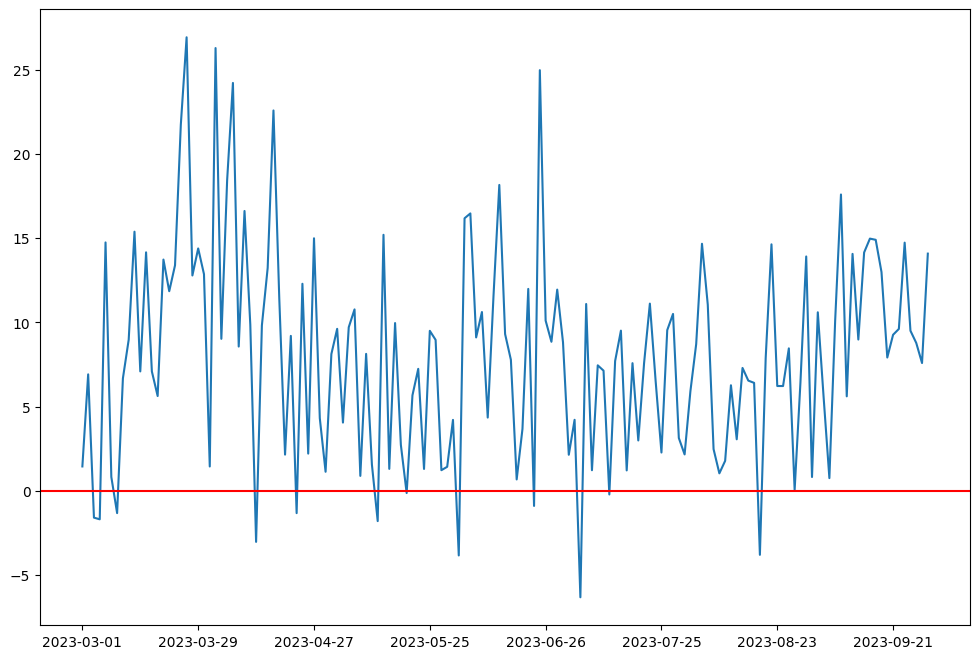

In [29]:
comp_df.diff(axis=1).iloc[:,1].plot(figsize=(12,8))
plt.axhline(0, c='r')

In [17]:
additional_trades = pd.read_pickle('predictions_additional_trades.pkl')

In [20]:
t = additional_trades[additional_trades.trade_date == '2023-03-01']
mean_absolute_error(t.new_ys, t.prediction)

46.141657355229206

In [21]:
QUERY = '''
SELECT * 
FROM `eng-reactor-287421.historical_predictions_test.historical_predictions_test` 
ORDER BY trade_date
'''

original_predictions = sqltodf(QUERY, bq_client)
original_predictions = original_predictions[original_predictions.rtrs_control_number.isin(additional_trades.rtrs_control_number)]

In [50]:
original_predictions.trade_date = pd.to_datetime(original_predictions.trade_date)

In [51]:
t2 = original_predictions[original_predictions.trade_date == '2023-03-01']
mean_absolute_error(t2.new_ys, t2.new_ys_prediction)

27.36256291850732

In [64]:
t2 = original_predictions[(original_predictions.trade_date >= '2023-07-01') & (original_predictions.trade_date < '2023-08-01')]
mean_absolute_error(t2.new_ys, t2.new_ys_prediction)

30.511434235935017